## PortfolioCrossSection.ipynb

Code for the Chicago Booth course on Quantitative Portfolio Management by Ralph S.J. Koijen and (current and former) teaching assistants Sangmin Oh, Federico Mainardi, and Laurenz de Rosa.

### Preliminaries

This code builds cross-sectional portfolio strategies and produces relevant analytics.
- As always, the data can be found in the dropbox folder: https://www.dropbox.com/scl/fo/ze2tut4prlptuyhuyofx4/AI7wV4q-6e-KDBSnRhyJptI?rlkey=93yaxhwrk0w8drx5d7o71cvow&dl=0. 
- Please download the file `MasterData_small.parquet`. 

In [22]:
import qpm_download
import qpm
import pandas as pd
import numpy as np
import wrds
import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

We now choose whether to import data directly from WRDS (`import_data` = True) or to load data from dropbpx (`import_data` = False). If you choose to load data from dropbox, make sure to define the data directoy (`_DATA_DIR`). Also, define a directory where you'd like to store the strategy returns (`_STRATEGY_DIR`). In future versions, we'll update the week. This means we'll be loading larger data sets. But we start with the file size needed only for size and value strategies.

In [23]:
import_data = False                # <-- Edit this line
_DATA_DIR = 'Data'           # <-- Edit this line
_STRATEGY_DIR = 'Strategy'   # <-- Edit this line

Next, we specify the strategy settings.
- First, we select the strategy name. At this point, we have `Value` and `Size`. We'll add more later.
- We can sort every month (`Monthly`) or only in June (`June`). As accounting data mostly comes out quarterly or annually, sorting once a year is often sufficient. As most companies have their fiscal year end in December, and we wait six months to make sure the data are available to investors, we sort in June.
- We can set `_REMOVE_MICRO_CAPS` to either `False` or `True`. If `True`, then we drop the smallest stocks. 
- The next two lines select the sample. 
- The final line selects the number of portfolios. We typically set this to 5 or 10.

In [24]:
_STRATEGY_NAME = 'ESG'      
_SORT_FREQUENCY = 'June'        # Either "Monthly" or "June"

_REMOVE_MICRO_CAPS = False      # Either "True" or "False"
_SAMPLE_START = '2014-01-01'    # For ESG data: '2014-01-01'
_SAMPLE_END = '2024-08-31'
_NUM_PORT = 5

### Step 1. Construct Signal

Let's first see which variables are available in the data:

In [25]:
qpm.list_variables(data_dir = _DATA_DIR, file_name = 'MasterData_small.parquet')

Identifiers:
['permno', 'ticker', 'comnam', 'conm']

Prices and Returns:
['ret', 'retx', 'prc', 'vwretd']

Fama-French:
['mktrf', 'smb', 'hml', 'rf', 'umd', 'rmw', 'cma']

Fundamentals:
['at', 'cogs', 'revt', 'be']

Others:
['vol', 'me', 'ESG_score', 'E_score', 'S_score', 'G_score', 'carbon_intensity']



We will work initially with a smaller data set `MasterData_small.parquet`, which is less demanding in terms of your computer's memory.

In [26]:
qpm.list_variables(data_dir = _DATA_DIR, file_name = 'MasterData_small.parquet')

Identifiers:
['permno', 'ticker', 'comnam', 'conm']

Prices and Returns:
['ret', 'retx', 'prc', 'vwretd']

Fama-French:
['mktrf', 'smb', 'hml', 'rf', 'umd', 'rmw', 'cma']

Fundamentals:
['at', 'cogs', 'revt', 'be']

Others:
['vol', 'me', 'ESG_score', 'E_score', 'S_score', 'G_score', 'carbon_intensity']



#### Load Data

Different strategies used different signals and different signals are based on different fundamentals. Thus, we first construct the list of fundamentals that we need to download or to load from Dropbox given the strategy that we specified in `_STRATEGY_NAME`.

In [27]:
signal_variables = qpm.return_signal(_STRATEGY_NAME)

Given the list of fundamentals needed to construct the strategy in `_STRAGEY_NAME`, we proceed to download the data or to load the data from Dropbox.

In [28]:
if import_data == True:

    df_full = qpm_download.cross_section_compact(_SAMPLE_START, _SAMPLE_END, _STRATEGY_NAME, signal_variables)
    
if import_data == False:
    
    df_full = qpm.load_data(data_dir = _DATA_DIR, file_name = 'MasterData_small.parquet', variable_list = signal_variables)

> Loading Raw Data...
> Renaming key variables...
> Dropping duplicates...
> Creating Auxiliary Variables...


#### Plot Key Variables

In [29]:
df_full.columns

Index(['umd', 'ldate', 'revt', 'at', 'hml', 'mktrf', 'rmw', 'exchcd', 'vol',
       'rf', 'shrout', 'retx', 'me', 'smb', 'carbon_intensity', 'ticker',
       'cogs', 'prc', 'conm', 'cma', 'be', 'permno', 'daret', 'shrcd',
       'profitA', 'ldate_lag', 'screen', 'ldate_lag12', 'screen12',
       'me_lagged'],
      dtype='object')

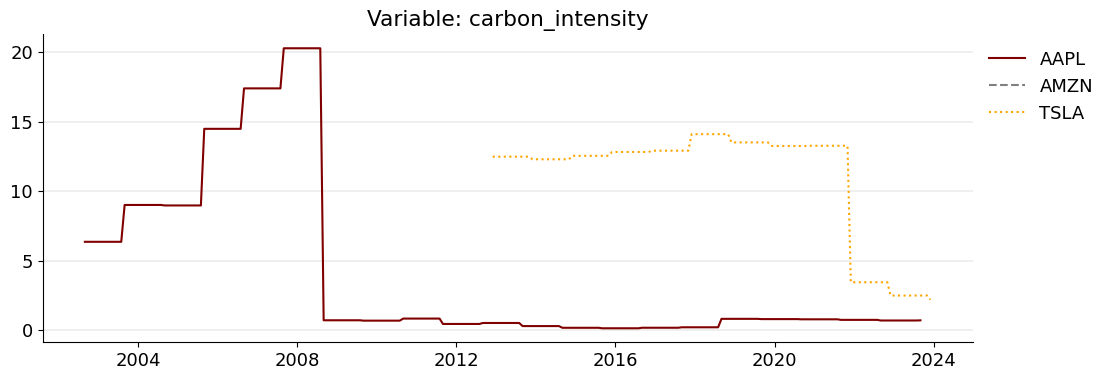

In [30]:
qpm.plot_variables(df_full, variable_list = ['carbon_intensity'],  id_type = 'ticker', id_list = ['AAPL', 'AMZN', 'TSLA'],
                     start_date = '1999-01-01', end_date = '2024-08-31')

#### Construct Signal

In [31]:
if _STRATEGY_NAME == 'Size':

	df_full['signal'] = -df_full['me']
	
elif _STRATEGY_NAME == 'Value':

	df_full['signal'] = df_full['be'] / df_full['me']

elif _STRATEGY_NAME == 'ESG':

	df_full['signal'] = -df_full['carbon_intensity']
        
else:
	
	raise Exception('Please provide a valid _STRATEGY_NAME..')  
    
df_sum = df_full.sort_values(['ldate','ticker'])	
print(df_sum[['ldate','ticker','me','signal']].loc[df_sum['ticker'].isin(['AAPL', 'AMZN', 'TSLA'])].tail(3))    

             ldate ticker            me  signal
127227  2024-09-01   AAPL  3.522211e+06     NaN
740737  2024-09-01   AMZN  1.958515e+06     NaN
1134702 2024-09-01   TSLA  8.390474e+05     NaN


#### Sample Selection

In [32]:
# Lag signal by one period so that the signal value is known at the time of portfolio creation
df_full['signal'] = qpm.create_lag(df_full, var_name = 'signal', lag = 1)

df = qpm.select_sample(df_full, sample_start = _SAMPLE_START, sample_end = _SAMPLE_END, remove_micro_caps = _REMOVE_MICRO_CAPS)

> Selecting Sample for Given Criteria...


### Step 2. Portfolio Construction

In [33]:
df, df_rets = qpm.create_portfolios(df, sort_frequency = _SORT_FREQUENCY, num_port = _NUM_PORT)
print(df_rets.tail())

> Sorting stocks into 5 portfolios at frequency: June...
> Computing returns using various weights...
         ldate  retP_rank_longonly  retP_rank_longshort  retP_vw_P1  \
117 2023-10-01           -0.081092             0.012187   -0.042916   
118 2023-11-01            0.107075             0.039947    0.043211   
119 2023-12-01            0.144991             0.040357    0.027990   
120 2024-01-01           -0.035057             0.002197   -0.004131   
121 2024-02-01           -0.002131            -0.057867         NaN   

     retP_vw_P2  retP_vw_P3  retP_vw_P4  retP_vw_P5   retF_vw  
117   -0.054237   -0.060361   -0.067861   -0.013381  0.029535  
118    0.092326    0.086221    0.092107    0.105311  0.062100  
119    0.082113    0.084316    0.052062    0.051854  0.023864  
120   -0.046090    0.004449   -0.019286    0.011804  0.015934  
121    0.039521   -0.038822         NaN         NaN       NaN  


### Step 3. Portfolio Analytics

> Merging strategy returns with Fama and French factor returns...


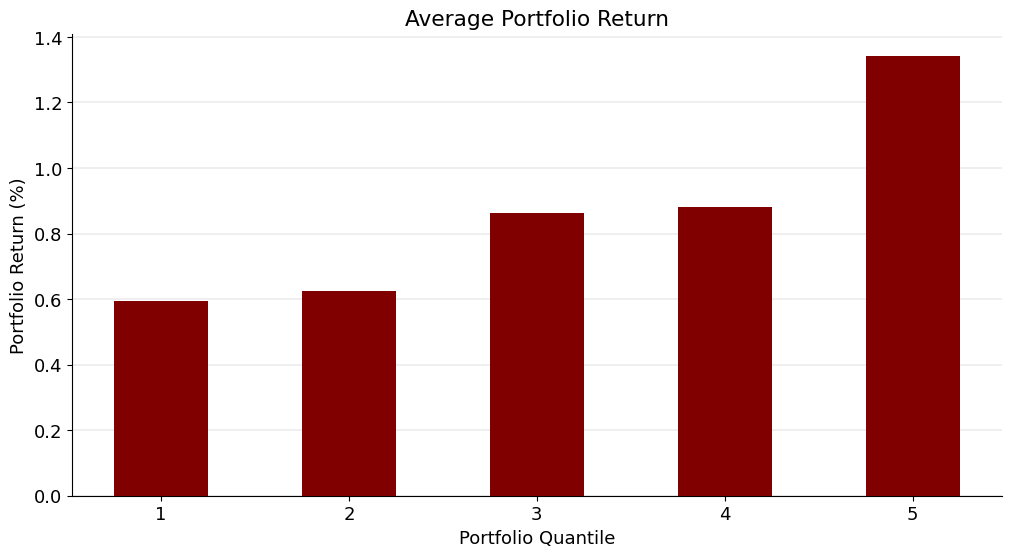

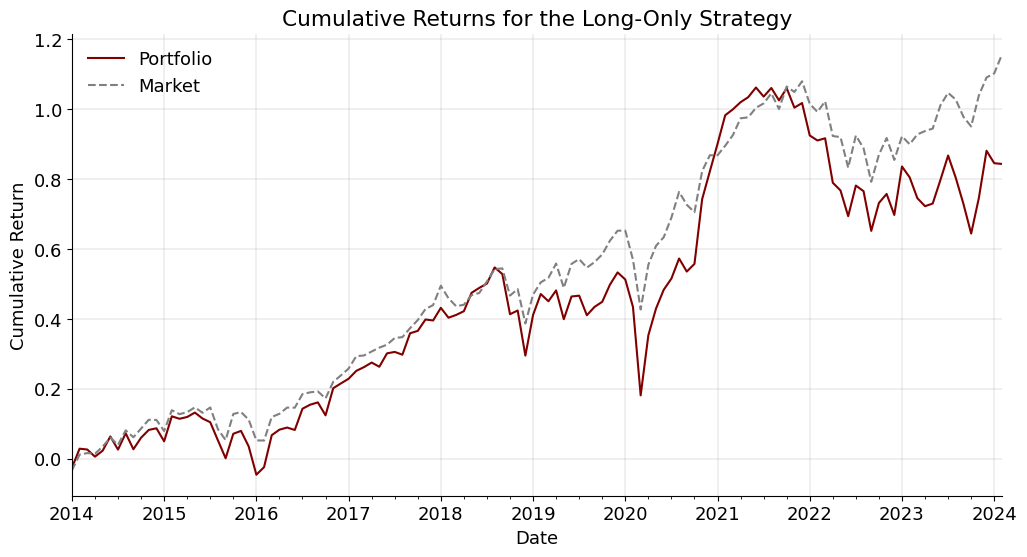

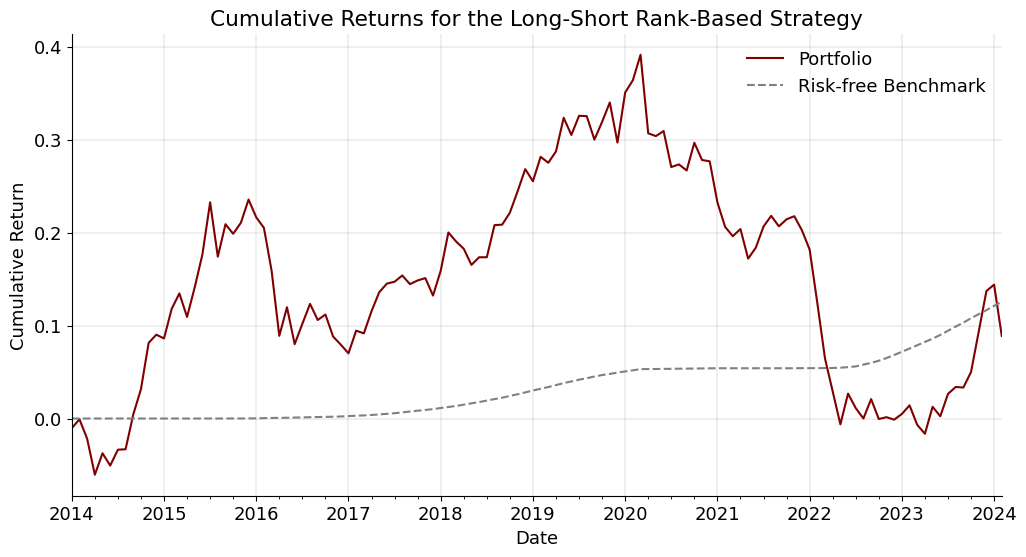

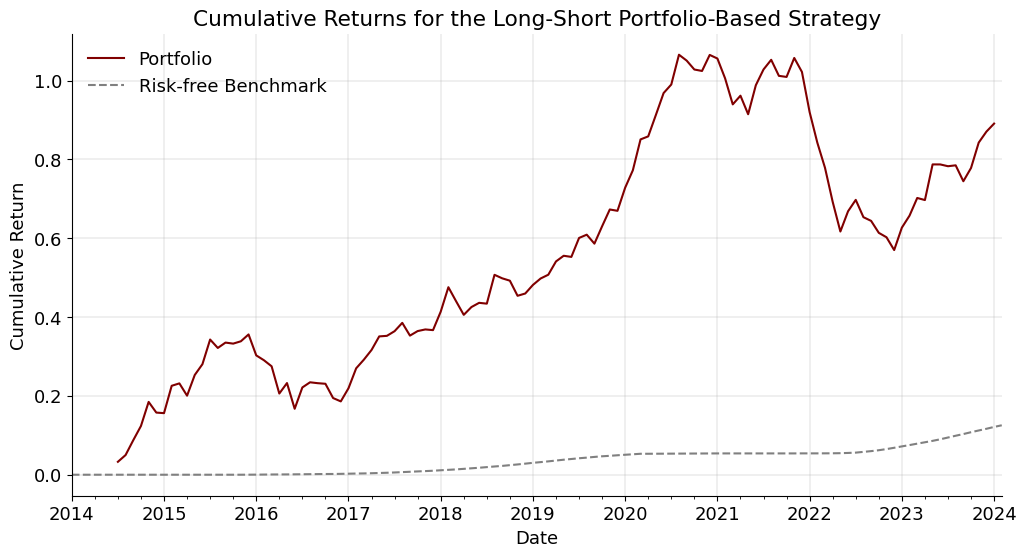

In [34]:
qpm.analyze_strategy(df_rets, analysis_type = 'Performance')

In [35]:
qpm.analyze_strategy(df_rets, analysis_type = 'Summary')

> Merging strategy returns with Fama and French factor returns...
                     count      mean       std       min       25%       50%  \
retP_rank_longonly   122.0  0.008814  0.061475 -0.223571 -0.024984  0.010760   
retP_rank_longshort  122.0  0.000054  0.026502 -0.081050 -0.015130  0.001948   
retF_vw              115.0  0.007498  0.039454 -0.096889 -0.014458  0.007731   
mktrf                122.0  0.009513  0.045304 -0.133900 -0.018650  0.011450   
smb                  122.0 -0.001868  0.029141 -0.082400 -0.022150 -0.001250   
hml                  122.0 -0.001811  0.037163 -0.138800 -0.020925 -0.004500   

                          75%       max  
retP_rank_longonly   0.038527  0.203653  
retP_rank_longshort  0.019976  0.057481  
retF_vw              0.035598  0.091028  
mktrf                0.033525  0.136500  
smb                  0.014800  0.073300  
hml                  0.016150  0.128000  


In [36]:
qpm.analyze_strategy(df_rets, analysis_type = 'Factor Regression')

> Merging strategy returns with Fama and French factor returns...

---------------------------------------------------------------
> Running Factor Regressions: Table 1  - 3 Fama-French Factors
---------------------------------------------------------------

                 (1)       (2)      (3)       (4)        (5)       (6)    
--------------------------------------------------------------------------
const          0.0060   -0.0035   0.0018   0.0044*    -0.0005   0.0012    
               (0.0037) (0.0026)  (0.0025) (0.0025)   (0.0012)  (0.0023)  
mktrf          0.1685** 1.2364*** -0.0919* 0.1877***  1.0607*** -0.0775   
               (0.0788) (0.0545)  (0.0529) (0.0572)   (0.0271)  (0.0526)  
hml                                        -0.7538*** 0.0064    -0.2435***
                                           (0.0696)   (0.0331)  (0.0640)  
smb                                        0.0022     0.8428*** -0.0389   
                                           (0.0941)   (0.0447)  (0

In [37]:
if _REMOVE_MICRO_CAPS:
    save_dir = '%s/StrategyReturns_%s_%s_noMicroCaps.csv' %(_STRATEGY_DIR, _STRATEGY_NAME, _SORT_FREQUENCY)
else:
    save_dir = '%s/StrategyReturns_%s_%s_withMicroCaps.csv' %(_STRATEGY_DIR, _STRATEGY_NAME, _SORT_FREQUENCY)

df_rets.to_csv(save_dir)
print('Saved Strategy Returns to %s' %(save_dir))

Saved Strategy Returns to Strategy/StrategyReturns_ESG_June_withMicroCaps.csv
